<a href="https://colab.research.google.com/github/davidtkeane/Google_Colab/blob/main/Phi3_Test_CoT_prompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# microsoft/Phi-3-mini-4k-instruct

The Phi-3-Mini-4K-Instruct is a 3.8B parameters, lightweight, state-of-the-art open model trained with the Phi-3 datasets that includes both synthetic data and the filtered publicly available websites data with a focus on high-quality and reasoning dense properties. The model belongs to the Phi-3 family with the Mini version in two variants 4K and 128K which is the context length (in tokens) that it can support.

The model has underwent a post-training process that incorporates both supervised fine-tuning and direct preference optimization for the instruction following and safety measures. When assessed against benchmarks testing common sense, language understanding, math, code, long context and logical reasoning, Phi-3 Mini-4K-Instruct showcased a robust and state-of-the-art performance among models with less than 13 billion parameters.


# Zero-shot COT Prompting
https://arxiv.org/abs/2205.11916

One recent idea that came out more recently is the idea of zero-shot CoT (Kojima et al. 2022) that essentially involves adding "Let's think step by step" to the original prompt. Let's try a simple problem and see how the model performs:

In [1]:
!pip install torch accelerate bitsandbytes datasets transformers peft trl scipy  deepspeed wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the 

#### HuggingFace URI
microsoft/Phi-3-mini-4k-instruct

In [2]:
import sys
import logging

import datasets
from datasets import load_dataset
from peft import LoraConfig
import torch
import transformers
from trl import SFTTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig

In [3]:
transformers.__version__

'4.47.1'

In [4]:
from google.colab import output
output.enable_custom_widget_manager()


In [5]:
#!/usr/bin/python3

# This block of code was made by Ranger and use it for when or what ever

!pip install colorama

# Loads Google Drive so you an save the model and then use it later for another time.

import os
import shutil
from google.colab import drive
from colorama import Fore, Style, init
from IPython.display import display, HTML

# Initialize colorama
init()

# Access the API key from Colab Secrets
from google.colab import userdata

try:
    api_key = userdata.get('GOOGLE_DRIVE_API')
    print(f"{Fore.GREEN}✅ API Key loaded successfully.{Style.RESET_ALL}")

    # Set the API key as an environment variable
    os.environ['GOOGLE_DRIVE_API'] = api_key
except Exception as e:
    print(f"{Fore.RED}❌ Error loading API Key: {e}{Style.RESET_ALL}")
    api_key = None

# Mount Google Drive using the API key (if available)
if api_key:
    try:
        # Use the API key to authenticate and mount Google Drive
        drive.mount('/content/drive', force_remount=True)
        print(f"{Fore.GREEN}✅ Google Drive mounted successfully using API Key.{Style.RESET_ALL}")
    except Exception as e:
        print(f"{Fore.RED}❌ Error mounting Google Drive: {e}{Style.RESET_ALL}")
else:
    print(f"{Fore.YELLOW}⚠️ No API Key found. Please log in manually.{Style.RESET_ALL}")
    drive.mount('/content/drive', force_remount=True)

# Define the Google Drive folder path
drive_folder = "/content/drive/MyDrive/Colab_Projects/Phi3-Test"

# Define the Colab working directory
colab_folder = "/content/"

# Ensure the Colab folder exists
os.makedirs(colab_folder, exist_ok=True)

# Function to count files in a directory
def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Function to sync files from Colab to Google Drive
def sync_to_drive():
    try:
        print(f"{Fore.CYAN}🔄 Syncing files from Colab to Google Drive...{Style.RESET_ALL}")

        # Use rsync to copy files from Colab to Google Drive
        os.system(f"rsync -av --progress {colab_folder}/ {drive_folder}/")

        print(f"{Fore.GREEN}✅ Files synced from Colab to Google Drive.{Style.RESET_ALL}")
    except Exception as e:
        print(f"{Fore.RED}❌ Error syncing to Google Drive: {e}{Style.RESET_ALL}")

# Function to sync files from Google Drive to Colab
def sync_from_drive():
    try:
        print(f"{Fore.CYAN}🔄 Syncing files from Google Drive to Colab...{Style.RESET_ALL}")

        # Count files before sync
        initial_count = count_files(colab_folder)

        # Use rsync to copy files from Google Drive to Colab
        # -a: Archive mode (recursive, preserves permissions, symlinks, etc.)
        # -v: Verbose output
        # --progress: Show progress during transfer
        # --ignore-existing: Skip files that already exist in the destination
        # old command = os.system(f"rsync -av --progress {drive_folder}/ {colab_folder}/")
        os.system(f"rsync -av --progress {drive_folder} {colab_folder}/")
        # Count files after sync
        final_count = count_files(colab_folder)
        files_transferred = final_count - initial_count

        print(f"{Fore.GREEN}✅ Sync completed!{Style.RESET_ALL}")
        print(f"{Fore.GREEN}📂 Files transferred: {files_transferred}{Style.RESET_ALL}")

        # List files in the Colab folder to confirm sync
        print(f"{Fore.BLUE}📁 Files in Colab folder:{Style.RESET_ALL}")
        for root, dirs, files in os.walk(colab_folder):
            for file in files:
                print(os.path.join(root, file))
    except Exception as e:
        print(f"{Fore.RED}❌ Error syncing from Google Drive: {e}{Style.RESET_ALL}")

# Function to display a sync button
def display_sync_button():
    display(HTML('''
        <div>
            <button onclick="syncFromDrive()">Sync from Google Drive to Colab</button>
            <button onclick="syncToDrive()">Sync from Colab to Google Drive</button>
            <button onclick="refreshPage()">Refresh</button>
        </div>
        <script>
            function syncFromDrive() {
                google.colab.kernel.invokeFunction('sync_from_drive', [], {});
            }
            function syncToDrive() {
                google.colab.kernel.invokeFunction('sync_to_drive', [], {});
            }
            function refreshPage() {
                window.location.reload();
            }
        </script>
    '''))

# Register the sync functions with Colab
from google.colab import output
output.register_callback('sync_from_drive', sync_from_drive)
output.register_callback('sync_to_drive', sync_to_drive)


# Display the sync button
display_sync_button()

✅ API Key loaded successfully.
Mounted at /content/drive
✅ Google Drive mounted successfully using API Key.


# microsoft/Phi-3-mini-4k-instruct
https://huggingface.co/microsoft/Phi-3-mini-4k-instruct



In [6]:
model_id = "microsoft/Phi-3-mini-4k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)

# --- Model Saving Code --- I added this into the block to save the model to google drive and so it will be saved for another time.
import os

save_directory = "/content/drive/MyDrive/Colab_Projects/Phi3-Test/model"
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
# --------------------------

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

[2025-01-10 20:39:53,881] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


('/content/drive/MyDrive/Colab_Projects/Phi3-Test/model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab_Projects/Phi3-Test/model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab_Projects/Phi3-Test/model/tokenizer.model',
 '/content/drive/MyDrive/Colab_Projects/Phi3-Test/model/added_tokens.json',
 '/content/drive/MyDrive/Colab_Projects/Phi3-Test/model/tokenizer.json')

In [7]:
memory_used = model.get_memory_footprint()
print("Memory footprint: {} GB".format(memory_used/1024/1024/1024))

Memory footprint: 7.117321014404297 GB


In [8]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Arrr, me hearties, I be a chatbot with a pirate's soul, here to assist ye on this fine day. What can this humble digital buccaneer do for ye?


In [9]:
tst = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.
Consider the posibility of having negative numbers

['i', 'P', 'h', '849', 'e', '3' ]

RESPONSE:
</INST>"""

In [10]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst},
]

EXPECTED ANSWER:

### RESPONSE:
The given list ['i', 'P', 'h', '849', 'e', '3'] contains the number 849 and 3, which is the only element of the list that is a number. Therefore, the final answer is 852.

Therefore the answer is 852

### End

In [11]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The elements in the list that are numbers are '849' and '3'. To find their sum, add them together:

849 + 3 = 852

So, the sum of the numbers in the list is 852.


In [12]:
tst_2 = """<INST>  Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.
Then I went again and bought 5 more apples and I ate 1 apple.
Answer: How many apples did I remain with?

### RESPONSE:
</INST>"""

'''
EXPECTED ANSWER:

### RESPONSE:
1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.
2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.
3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.

### End'''

In [13]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_2},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

You initially bought 10 apples. You gave away 2 apples to the neighbor and 2 apples to the repairman, which leaves you with 10 - 2 - 2 = 6 apples. Then, you bought 5 more apples, increasing your total to 6 + 5 = 11 apples. After eating 1 apple, you are left with 11 - 1 = 10 apples. So, you remained with 10 apples.


In [14]:
tst_3 = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old.
Answer how old is my sister now?

### RESPONSE:
</INST>"""

# Expected response

67 years old

In [15]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_3},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

When you were 6 years old, your sister was half your age, which means she was 3 years old. The age difference between you and your sister is 3 years (6 - 3 = 3). Now that you are 70 years old, we can calculate your sister's age by subtracting the age difference from your current age: 70 - 3 = 67. So, your sister is 67 years old now.


In [16]:
tst_4 = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?

### RESPONSE:
</INST>"""

# Response expected 57 years old

In [17]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_4},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Answer: You are 57 years old now.

Rationale: If you had a car 20 years ago and you were 37 years old at that time, you simply add the 20 years to your age back then to find your current age. So, 37 + 20 = 57 years old.


In [18]:
tst_5 = """<INST>Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I had a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?

### RESPONSE:
</INST>"""

In [19]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_5},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

To calculate the value of the car using the Percentage (Declining Balance) method, we need to apply the annual depreciation rate of 5% to the car's value each year for 20 years.

Here's the formula for the Percentage (Declining Balance) method:

Value_n = Value_(n-1) * (1 - Depreciation_Rate)

Where:
- Value_n is the value of the car after n years
- Value_(n-1) is the value of the car after (n-1) years
- Depreciation_Rate is the annual depreciation rate (in this case, 5% or 0.05)

Let's calculate the value of the car after 20 years:

Initial value of the car (Value_0) = $100,000

For each year (n), we will apply the formula:

Value_n = Value_(n-1) * (1 - 0.05)

After 20 years (n = 20), the value of the car (Value_20) will be:

Value_20 = Value_19 * (1 - 0.05)

We can use a loop to calculate the value of the car after each year:

Value_0 = 100000

for i in range(1, 21):
    Value_0 = Value_0 * (1 - 0.05)

After running this loop, we find that the value of the car after 20 years (Value_2

In [20]:
tst_5b = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I bought a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?
Let,s think step by step

### RESPONSE:
</INST>"""

In [21]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_5b},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

To calculate the current value of the car using the Percentage (Declining Balance) method, we need to follow these steps:

1. Determine the initial cost of the car: $100,000
2. Determine the annual depreciation rate: 5%
3. Calculate the depreciation for each year and subtract it from the previous year's value.

Let's calculate the value of the car after each year for 20 years:

Year 1:
Depreciation = 100,000 * 0.05 = $5,000
Value after Year 1 = 100,000 - 5,000 = $95,000

Year 2:
Depreciation = 95,000 * 0.05 = $4,750
Value after Year 2 = 95,000 - 4,750 = $90,250

Year 3:
Depreciation = 90,250 * 0.05 = $4,512.50
Value after Year 3 = 90,250 - 4,512.50 = $85,737.50

Continue this process for 20 years:

Year 20:
Depreciation = 33,548.39 * 0.05 = $1,677.42
Value after Year 20 = 33,548.39 - 1,677.42 = $31,870.97

So, using the Percentage (Declining Balance) method, the value of the car after 20 years is approximately $31,870.97.


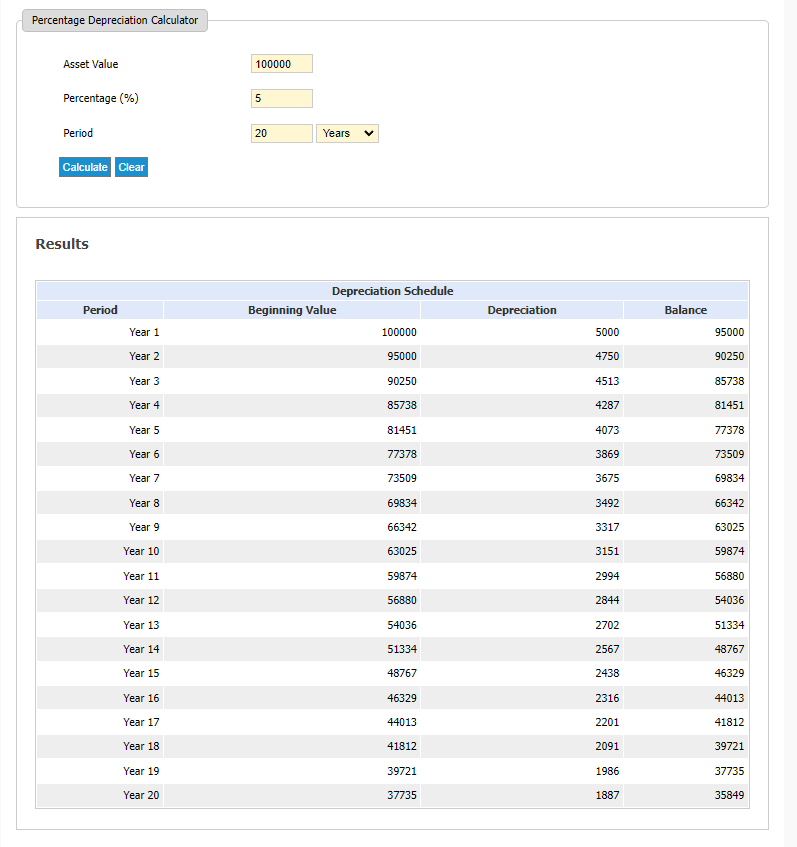